In [2]:
from ipywidgets import GridspecLayout, Output
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy
import scipy.misc
import time
import scipy.ndimage
import random
import torch
import torchvision
from torchvision.transforms.functional import normalize
import matplotlib.cm as cm
sys.path.insert(0, '../src')
random.seed(42)

In [3]:
from ebconv.splines import BSplineElement
from ebconv.kernel import CardinalBSplineKernel, create_random_centers
from ebconv.utils import round_modf, tensordot
from ebconv.nn.functional import cbsconv

# BSplines examples

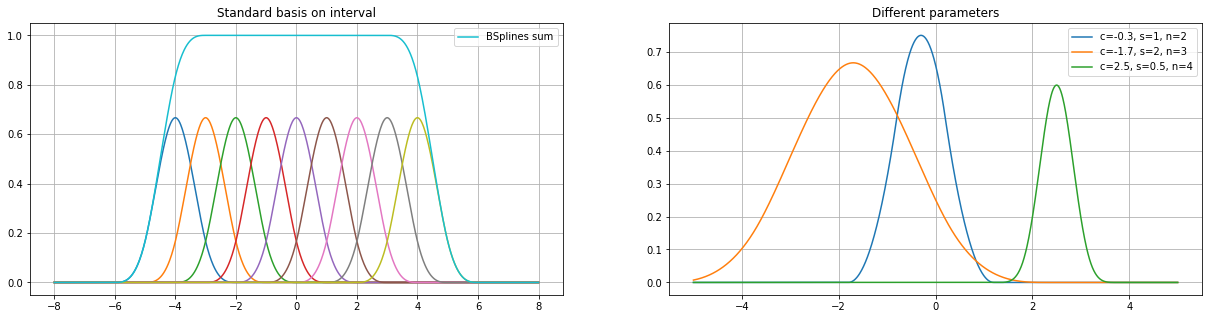

In [4]:
def b_splines_example():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 5))
    x = np.linspace(-8, 8, 1000)
    s = np.zeros_like(x)
    for c in np.arange(-4, 4 + 1):
        b = BSplineElement.create_cardinal(c)
        y = b(x)
        s += y
        ax1.plot(x, y)
    ax1.plot(x, s, label='BSplines sum', linewidth=1.5)
    ax1.grid()
    ax1.legend()
    ax1.set_title("Standard basis on interval")

    x = np.linspace(-5, 5, 1000)
    for s, c, n in zip((1, 2, 0.5), (-0.3, -1.7, 2.5), (2, 3, 4)):
        b = BSplineElement.create_cardinal(c, s, n)
        ax2.plot(x, b(x), label=f'c={c}, s={s}, n={n}')
    ax2.grid()
    ax2.legend()
    ax2.set_title("Different parameters")
    plt.show()

b_splines_example()

# 2D BSpline Kernel basis

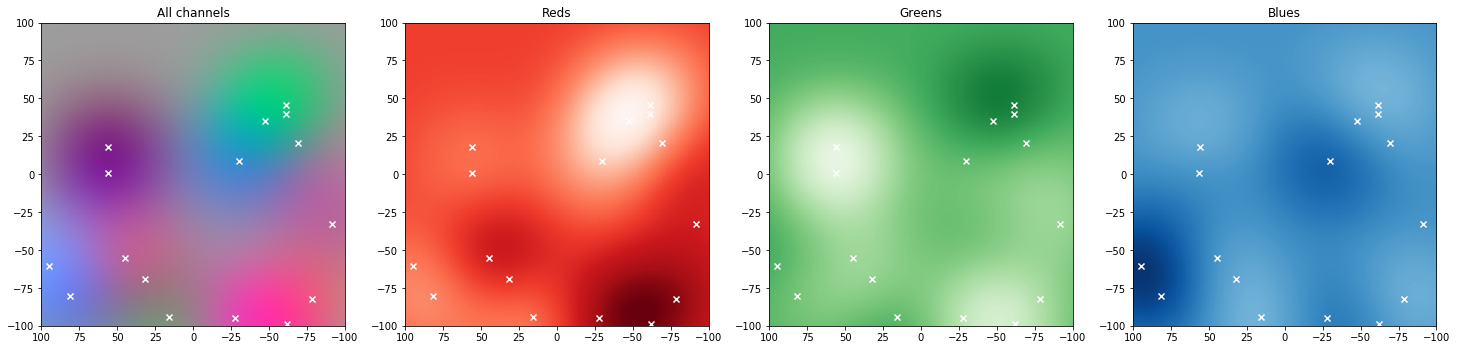

In [5]:
def bsplinekernel_example(N=16, s=48, k=3):
    """Example of how to use the BSplineKernelBasis.
    
    This is a simple example on how to generate 
    a set of randomly centered basis spline functions.
    """
    # 2d interval, sample from top left to bottom right
    # in this way the value (0, 0) corresponds to (-100, 100).
    interval = np.array((100, -100, -100, 100)).reshape(2, 2)
    c = create_random_centers(interval, N)
    
    kb = CardinalBSplineKernel.create(c=c, s=s, k=k)
    bounds = interval #kb.centered_bounds()
    axb = bounds.flatten()

    # We need to flip the axes boundaries because
    # we want to sample from top left to bottom left
    # and from top left to top right
    bounds = np.flip(bounds, axis=0)
    bounds[0, :] = np.flip(bounds[0, :])
    bounds = bounds.T
    
    # Now we generate three sets of random weights
    w = np.random.rand(3, N) * 2 - 1
    
    # Generate the meshgrid
    np.meshgrid(*np.linspace(*bounds, 200).T)
    xx, yy = np.meshgrid(*np.linspace(*bounds, 200).T)
    
    # Compute the linear combination of bases
    tb = kb(xx, yy)
    k = np.tensordot(w, tb, axes=1).T
    k = np.interp(k, (k.min(), k.max()), (0, 1))
    
    fig, axes = plt.subplots(1, 4, figsize=(25, 8))
    axes[0].scatter(*kb.c.T, marker='x', color='white')
    axes[0].imshow(k, extent=axb)
    axes[0].set_title('All channels')
    k_channels = (k[..., 0], k[..., 1], k[..., 2])
    for ax, c, cmap in zip(axes[1:], k_channels, ('Reds', 'Greens', 'Blues')):
        ax.scatter(*kb.c.T, marker='x', color='white')
        ax.imshow(c, extent=axb, cmap=cmap, vmin=0, vmax=1)
        ax.set_title(cmap)
    plt.show()
    return kb, w, interval

kb, w, interval = bsplinekernel_example()

# Example of a 2d convolution

In [ ]:
def standard_convolution(img, kb, w, interval):
    # We sample a 2d kernel
    linspaces = []
    steps = []
    for lb, ub in interval:
        x, step = np.linspace(lb, ub, 100, retstep=True)
        linspaces.append(x)
        steps.append(step)
    xx, yy = np.meshgrid(*np.linspace(*zip(*interval), 100).T)

    # Construct the per channel kernel weights
    k = torch.Tensor(np.tensordot(w, kb(xx, yy), axes=1).T)
    weights = torch.stack((k[:, :, 0][None, :], 
                           k[:, :, 1][None, :], 
                           k[:, :, 2][None, :]))
    conv = torch.nn.functional.conv2d(img, weights, groups=3)
    
    conv = conv.numpy().squeeze()
    conv = np.moveaxis(conv, 0, -1)
    conv = np.interp(conv, (conv.min(), conv.max()), (0, 1))
    return conv

def bspline_convolution(img, kb, w, interval):
    oC, n = w.shape
    w = torch.Tensor(w).reshape(oC, 1, n)
    cbsconv(img, w, kb.c, kb.s, kb.k)

def convolutions_example(kb, w, interval):
    # Our test image
    img = scipy.misc.face()
    img = torch.Tensor(np.moveaxis(img, -1, 0))
    #img = normalize(img, (0, 0, 0), (100, 100, 100))
    img = img[None, :]
    
    #start_time = time.time()
    #conv = standard_convolution(img, kb, w, interval)
    
    conv = bspline_convolution(img, kb, w, interval)
    #plt.figure()
    #plt.title('Standard convolution (%.2fs)' % (time.time() - start_time))
    #plt.imshow(conv)
    #plt.show()
    
_ = convolutions_example(kb, w, interval)


In [ ]:
def _compute_shifts(centers):
    shifts = {}
    for c in centers:
        dshifts, ishifts = tuple(zip(*(round_modf(v) for v in c)))
        shifts[c] = tuple(zip(*(round_modf(v) for v in c)))
    return shifts


shifts = _compute_shifts(((0.3, 1.6), (7.8, -9.1)))

In [ ]:
shifts[(0.3, 1.6)]


In [ ]:
def _compute_subconvs_params(c, s, k):
    # Reshape in a convenient way
    # Iterate through dim, basis, c, s, k
    # Awful and unreadable magick trick to iterate
    # in the right order.
    parameters = zip(*[tuple(zip(*x)) for x in zip(c, s, k)])
    for dim_params in parameters:
        for centers_params in dim_params:
            print(centers_params)


In [ ]:
c = ((1, 2, 3), (4, 5, 6), (7, 8, 9))
s = (('a', 'b', 'c'), ('d', 'e', 'f'), ('g', 'h', 'i'))
k = ((1.0, 2.0, 3.0), (4.0, 5.0, 6.0), (7.0, 8.0, 9.0))
_compute_subconvs_params(c, s, k)